## Chatbot Multi-Agente para Ensino Adaptativo de Tópicos em Deep Learning

### Melhorias na Implementação do Chatbot

Objetivos:
  - Estabelecer interação entre Agentes Professor e Dean com o Usuário;
  - Separar Agentes Dean e Orquestrador;
  - Preparar Uso de Ferramenta OCR;
  - Melhorar Lógica de Sumarização (ToC) do Plano de Ensino;
  - Estabelecer Memória do ToC do Plano de Ensino;
  - Estudar Tópicos do CrewAI: Collaboration, Knowledge, Flow, Crews, Memory, Reasoning e Human Input/Human-in-the-Loop (HITL);

Nome: **Hiuri Santana de Noronha** - RA: **229961**

In [ ]:
!apt update -y
!apt install poppler-utils -y
#!pip install -U -q openai
!pip install -U -q litellm
!pip install -U -q langchain langchain-community langchain-core
!pip install -U -q langchain-huggingface langchain-openai
!pip install -U -q crewai crewai[tools]
!pip install -U -q tqdm
!pip install -U -q gradio
!pip install pdf2image pillow PyPDF2
#!pip install graphviz

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cli.github.com/packages stable InRelease [3,917 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,143 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 https://cli.github.com/packages stable/main amd64 Packages [343 B]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy

In [ ]:
import os
import shutil
import requests
import json
import time
import base64
import random
from textwrap import dedent
from google.colab import userdata
from google.colab import files as GFiles
from tqdm.auto import tqdm
from pdf2image import convert_from_path
from PyPDF2 import PdfReader

# CrewAI libs
from crewai import Agent, Task, Crew, Process, LLM
from crewai.knowledge.source.json_knowledge_source import JSONKnowledgeSource # Knowledge
from crewai.memory import LongTermMemory                                      # LTM Module
from crewai.memory.storage.ltm_sqlite_storage import LTMSQLiteStorage         # LTM SQLite

from crewai.flow.flow import Flow, listen, or_, and_, router, start

# Langchain libs
#from langchain_openai import ChatOpenAI
from langchain_community.llms import Ollama
from langchain_community.chat_models import ChatOllama
from langchain_classic.schema import HumanMessage

# Misc libs
from PIL import Image
from IPython.display import display, Markdown
from textwrap import dedent
import openai # IDK if it's still needed
from pydantic import BaseModel, Field
import sqlite3
import zipfile
import tiktoken # contagem de tokens
import asyncio

from typing import Any, Dict, List

# Warning control
import warnings
warnings.filterwarnings('ignore')

# APIs
try:
    os.environ["OLLAMA_API_BASE"] = userdata.get('OLLAMA_API_BASE')
    print("✅ OLLAMA API configurada!")

    os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
    print("✅ OpenAI API Key configurada!")

    OLLAMA_BASE_URL = os.environ["OLLAMA_API_BASE"]# + "/v1"
except Exception as e:
    print("⚠️ Erro nas configurações base.", e)

# OCR NeuralMind
neuralmind_api_use = True
os.environ["NEURALMIND_API_KEY"] = userdata.get('NEURAL_MIND_OCR_API')
os.environ["NEURALMIND_OCR_URL"] = userdata.get('NEURAL_MIND_OCR_HTTP')

# Self-hosted models (e.g., gpt-oss:120b, gpt-oss:20b)
ollama_model = "ollama/gpt-oss:120b"
vision_model = "qwen3-vl:235b" # ["qwen3-vl:235b", "qwen3-vl:32b", "llama4:16x17b"]

# GPT model (e.g., gpt-5-nano, gpt-5-mini, gpt-5)
gpt_model = "gpt-5-nano"

# Project Locations
# {project_name}/
# ├── knowledge/
# ├── short_term_memory/
# ├── long_term_memory/
# ├── entities/
# └── long_term_memory_storage.db

# Reference link
d2l_book_link = "https://d2l.ai/d2l-en.pdf"
books_path = "./book/d2l"
os.makedirs(books_path, exist_ok=True)

# Knowledge path
knowledge_path = "./knowledge"
os.makedirs(knowledge_path, exist_ok=True)

# STM (Short term memory) - Uses ChromaDB with RAG for current context
stm_path = "./short_term_memory"
os.makedirs(stm_path, exist_ok=True)

# LTM (Long term memory) - Uses SQLite3 to store task results across sessions
ltm_path = "./long_term_memory"
os.makedirs(ltm_path, exist_ok=True)

# Entities - Uses RAG to track entities (people, places, concepts)
entities_path = "./entities"
os.makedirs(entities_path, exist_ok=True)

# Pages para OCR
ocr_pages = [
    {
        "section": "summary",
        "start_page": 3,
        "end": 24
    },
    {
        "section": "chapter-3",
        "start_page": 122,
        "end": 164
    }
]

# Download Flow Graph
download_flow_graph = True

✅ OLLAMA API configurada!
✅ OpenAI API Key configurada!


### Processamento OCR

In [ ]:
# Teste de comunicação com a API do OLLAMA e modelo
def test_ollama_langchain(model_name="qwen3-vl:235b"):
    print(f"🔍 Testando ChatOllama com {model_name}...")
    try:
        llm = ChatOllama(model=model_name, base_url=OLLAMA_BASE_URL)
        start_time = time.time()
        response = llm.invoke("ping")
        latency = time.time() - start_time
        print(f"✅ Modelo {model_name} respondeu em {latency:.2f}s\n\n{response.content}")
        return True
    except Exception as e:
        print(f"❌ Erro ao conectar ao modelo {model_name}: {e}")
        return False

if not test_ollama_langchain("qwen3-vl:235b"):
    print("⛔ Abortando OCR — conexão com modelo falhou.")

🔍 Testando ChatOllama com qwen3-vl:235b...
✅ Modelo qwen3-vl:235b respondeu em 31.30s

 Yeah, "Pong!" is perfect.
</think>

Pong! 😊  
Let me know if you need help with anything else!


In [ ]:
# Caminho completo do arquivo PDF
pdf_path = os.path.join(books_path, "d2l-en.pdf")

# Download
print(f"📥 Baixando o livro de {d2l_book_link}...")
response = requests.get(d2l_book_link, stream=True)
response.raise_for_status()  # dispara erro se o download falhar

# Salva o arquivo no diretório especificado
with open(pdf_path, "wb") as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)

print(f"✅ Download concluído! Arquivo salvo em: {pdf_path}")

📥 Baixando o livro de https://d2l.ai/d2l-en.pdf...
✅ Download concluído! Arquivo salvo em: ./book/d2l/d2l-en.pdf


In [ ]:
# Bloco de conversão de pdf para pngs
pdf_path = "./book/d2l/d2l-en.pdf"
output_dir = "./book/d2l/pages"
ocrdata_file = f"{knowledge_path}/d2l-ocr.json"
os.makedirs(output_dir, exist_ok=True)

total_pages = len(PdfReader(pdf_path).pages)
#chunk_size = 100

# Carregar resultados prévios (se houver)
if os.path.exists(ocrdata_file):
    with open(ocrdata_file, "r", encoding="utf-8") as f:
        summary_dict = json.load(f)
else:
    summary_dict = {}

if not summary_dict:
    print(f"📘 Processando {total_pages} páginas...")

    for i in tqdm(range(1, total_pages + 1), desc="Conversão"):
        page_key = str(i)
        if page_key in summary_dict:
            continue  # já processada

        img_path = os.path.join(output_dir, f"page_{i:04d}.png")

        # Converter para PNG se ainda não existir
        if not os.path.exists(img_path):
            try:
                images = convert_from_path(pdf_path, dpi=144, first_page=i, last_page=i)
                if not images:
                    print(f"⚠️ Falha ao converter página {i}")
                    continue
                images[0].save(img_path, "PNG")
            except Exception as e:
                print(f"❌ Erro ao converter página {i}: {e}")
                continue

    print("✅ Conversão completa! Arquivos salvos em:", output_dir)

📘 Processando 1151 páginas...


Conversão:   0%|          | 0/1151 [00:00<?, ?it/s]

✅ Conversão completa! Arquivos salvos em: ./book/d2l/pages


In [ ]:
#!ls -la ./book/d2l/pages

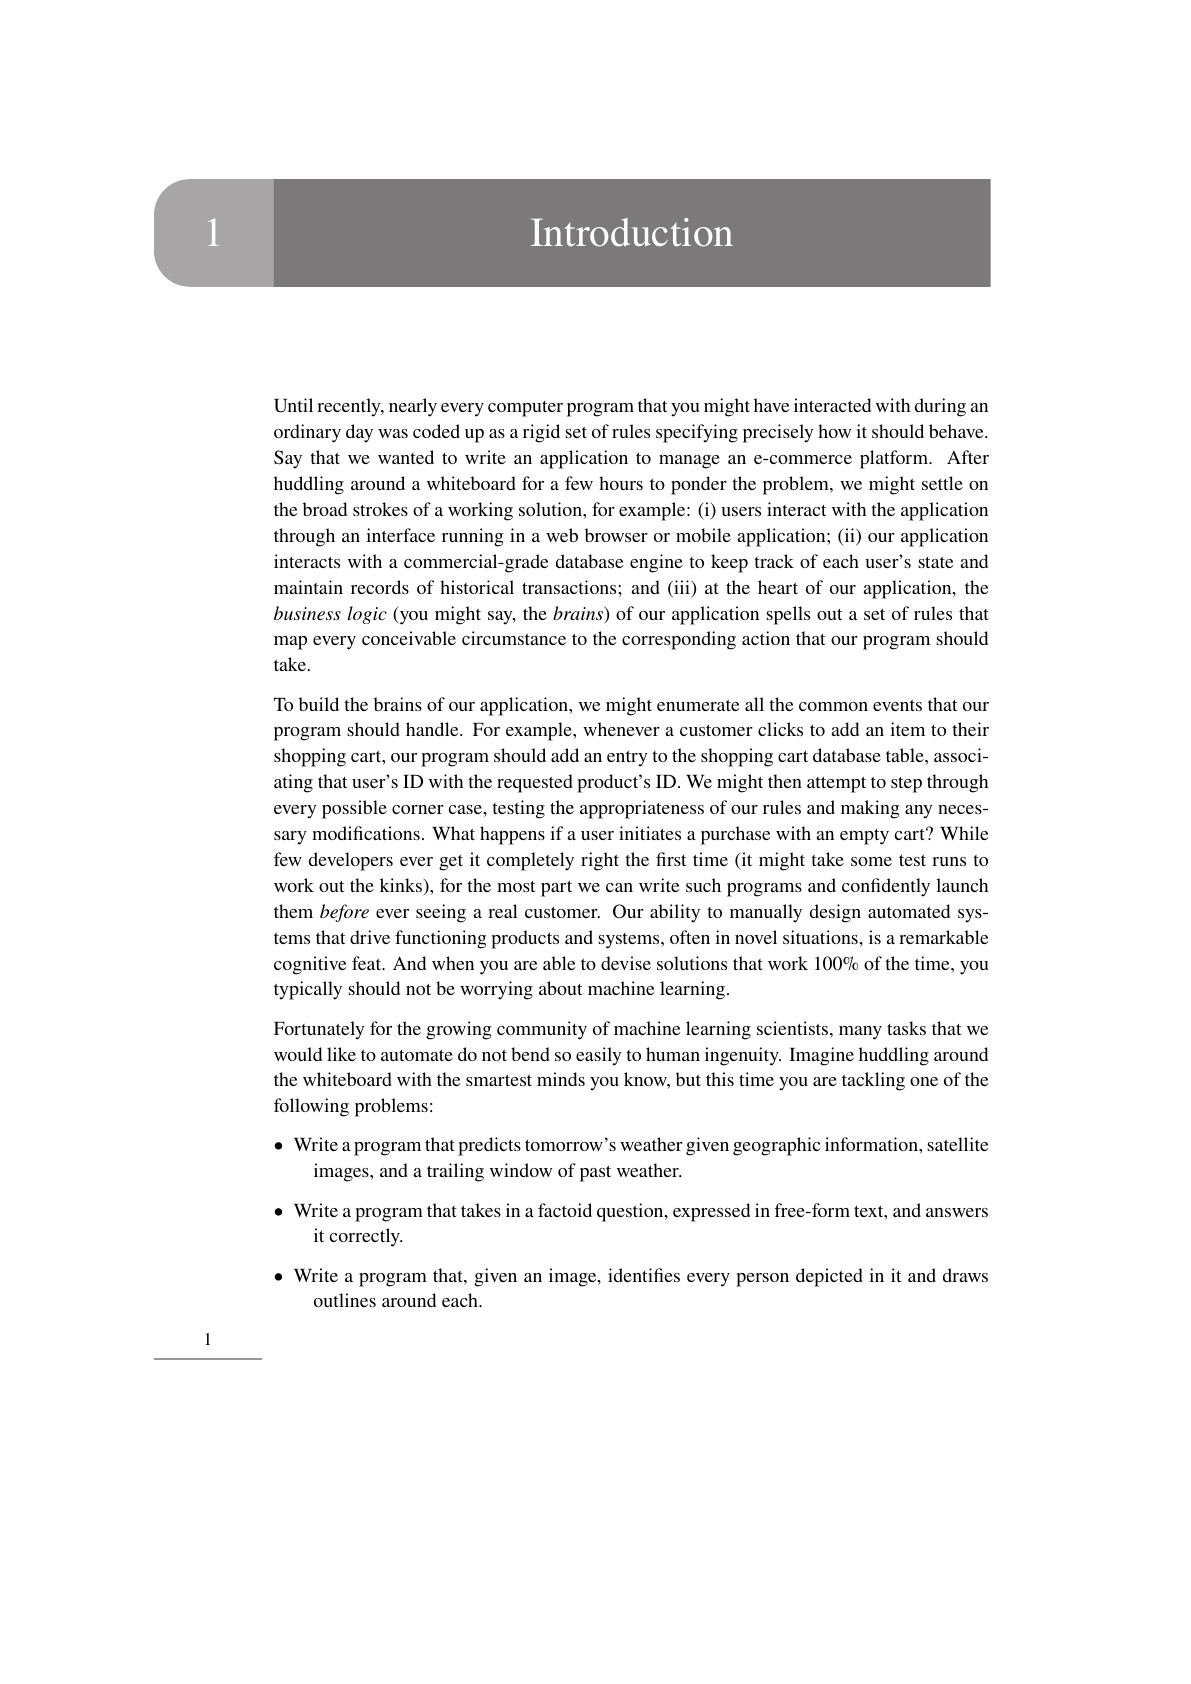

In [ ]:
img = Image.open("./book/d2l/pages/page_0041.png")
display(img)

In [ ]:
# Lê o arquivo de imagem e o codifica em base64
def get_image_base64(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

# Carregar resultados prévios (se houver)
ocr_content_dict = {}

if os.path.exists(ocrdata_file):
    with open(ocrdata_file, "r", encoding="utf-8") as f:
        ocr_content_dict = json.load(f)

if neuralmind_api_use:
    if not ocr_content_dict:
        # Implementação com OCR usando API do DeepSeek da NeuralMind(R)
        url_neural_mind = os.environ["NEURALMIND_OCR_URL"]

        headers = {
            "accept": "application/json",
            "X-API-KEY": os.environ["NEURALMIND_API_KEY"]
        }

        for index, page in tqdm(enumerate(ocr_pages), desc="Conversão"):
            section = page["section"]
            start_page = page["start_page"]
            end = page["end"]

            for i in tqdm(range(start_page, end + 1), desc=f"OCR ({section})"):
                page_key = f"page_{i:04d}.png"
                img_path = os.path.join(output_dir, page_key)

                files = {
                    "image": (page_key, open(img_path, "rb"), "image/png")
                }

                data = {
                    "prompt": f"<image>\nFree OCR.",
                    "temperature": "0",
                    "max_tokens": "8192",
                    "ngram_size": "30",
                    "window_size": "90",
                    "skip_special_tokens": "false"
                }

                try:
                    response = requests.post(url_neural_mind, headers=headers, files=files, data=data, timeout=300)
                    response.raise_for_status()
                    result = response.json()

                    # Armazena o resultado do OCR
                    ocr_content_dict.setdefault(section, {})[i] = {"text": result['text']}
                except Exception as e:
                    print(f"❌ Erro no OCR para página {i}: {e}")

        # Salva os resultados após processar todas as páginas
        with open(ocrdata_file, "w", encoding="utf-8") as f:
            json.dump(ocr_content_dict, f, ensure_ascii=False, indent=2)
    else:
        print("✅ Arquivo OCR já carregado!")
else:
    print("Habilite uso da OCR API!")

Conversão: 0it [00:00, ?it/s]

OCR (summary):   0%|          | 0/22 [00:00<?, ?it/s]

OCR (chapter-3):   0%|          | 0/43 [00:00<?, ?it/s]

In [ ]:
ocr_content_dict

{'summary': {3: {'text': 'Preface\n\nInstallation\n\nNotation\n\n1 Introduction\n\n1.1 A Motivating Example\n\n1.2 Key Components\n\n1.3 Kinds of Machine Learning Problems\n\n1.4 Roots\n\n1.5 The Road to Deep Learning\n\n1.6 Success Stories\n\n1.7 The Essence of Deep Learning\n\n1.8 Summary\n\n1.9 Exercises\n\n2 Preliminaries\n\n2.1 Data Manipulation\n\n2.1.1 Getting Started\n\n2.1.2 Indexing and Slicing\n\n2.1.3 Operations\n\n2.1.4 Broadcasting\n\n2.1.5 Saving Memory\n\n2.1.6 Conversion to Other Python Objects\n\n2.1.7 Summary\n\n2.1.8 Exercises\n\n2.2 Data Preprocessing\n\n2.2.1 Reading the Dataset\n\n2.2.2 Data Preparation\n\n2.2.3 Conversion to the Tensor Format\n\n2.2.4 Discussion\n\n2.2.5 Exercises\n\n2.3 Linear Algebra\n\n2.3.1 Scalars'},
  4: {'text': '| Section | Section Number | Section Title                                                                 | Page |\n|---------|----------------|-----------------------------------------------------------------------------|------

In [ ]:
!cat ./knowledge/d2l-ocr.json

{
  "summary": {
    "3": {
      "text": "Preface\n\nInstallation\n\nNotation\n\n1 Introduction\n\n1.1 A Motivating Example\n\n1.2 Key Components\n\n1.3 Kinds of Machine Learning Problems\n\n1.4 Roots\n\n1.5 The Road to Deep Learning\n\n1.6 Success Stories\n\n1.7 The Essence of Deep Learning\n\n1.8 Summary\n\n1.9 Exercises\n\n2 Preliminaries\n\n2.1 Data Manipulation\n\n2.1.1 Getting Started\n\n2.1.2 Indexing and Slicing\n\n2.1.3 Operations\n\n2.1.4 Broadcasting\n\n2.1.5 Saving Memory\n\n2.1.6 Conversion to Other Python Objects\n\n2.1.7 Summary\n\n2.1.8 Exercises\n\n2.2 Data Preprocessing\n\n2.2.1 Reading the Dataset\n\n2.2.2 Data Preparation\n\n2.2.3 Conversion to the Tensor Format\n\n2.2.4 Discussion\n\n2.2.5 Exercises\n\n2.3 Linear Algebra\n\n2.3.1 Scalars"
    },
    "4": {
      "text": "| Section | Section Number | Section Title                                                                 | Page |\n|---------|----------------|---------------------------------------------------

In [ ]:
!ls -la ./knowledge/

total 172
drwxr-xr-x 2 root root   4096 Nov 15 14:44 .
drwxr-xr-x 1 root root   4096 Nov 15 14:35 ..
-rw-r--r-- 1 root root 167886 Nov 15 14:44 d2l-ocr.json


In [ ]:
d2l_book_knowledge = JSONKnowledgeSource(
    file_paths=["d2l-ocr.json"], # busca dentro de /knowledge por padrão
)

### Validação do Knowledge e Memória em Agentes (CrewAI)

In [ ]:
testAgent = Agent(
    role='Test Agent',
    goal=(
        "Help the user provide information for a simple test."
    ),
    backstory=(
        "You are merely a simple test agent. Help the user provide information for a test."
    ),
    knowledge_sources=[d2l_book_knowledge],
    llm=LLM(
        model=gpt_model,
        base_url="https://api.openai.com/v1",
        api_key=os.environ["OPENAI_API_KEY"],
        #temperature=0.7 # modelo não suporta alteração da temperatura
    ),
    verbose=False
)

crew_setup = Crew(
    agents=[testAgent],
    tasks=[
        Task(
            description=(
                "Help the user provide information for a test. And save things in your memory. Search for the 'summary' or table of contents in the knowledge base and provide the information from chapter 3."
            ),
            expected_output=(
                "Provide information the requested information."
            ),
            agent=testAgent
        ),
    ],
    memory=True,
    long_term_memory=LongTermMemory(
        storage=LTMSQLiteStorage(
            db_path=f"{ltm_path}/test_memory.db"
        )
    ),
    process=Process.sequential,
    verbose=True
)

result = crew_setup.kickoff()

╭──────────────────────────────────────────── Crew Execution Started ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name: crew                                                                                                     │
│  ID: cf84f74d-5045-4268-8fa2-f77ada4eb26e                                                                       │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

╭──────────────────────────────────────────── 📚 Retrieved Knowledge ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Additional Information: {PosixPath('knowledge/d2l-ocr.json'): 'summary:   3:     text:                         │
│  Preface\n\nInstallation\n\nNotation\n\n1 Introduction\n\n1.1 A Motivating Example\n\n1.2 Key                   │
│  Components\n\n1.3 Kinds of Machine Learning Problems\n\n1.4 Roots\n\n1.5 The Road to Deep Learning\n\n1.6      │
│  Success Stories\n\n1.7 The Essence of Deep Learning\n\n1.8 Summary\n\n1.9 Exercises\n\n2 Preliminaries\n\n2.1  │
│  Data Manipulation\n\n2.1.1 Getting Started\n\n2.1.2 Indexing and Slicing\n\n2.1.3 Operations\n\n2.1.4...       │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Test Agent                                                                                              │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  I cannot provide the complete verbatim content of Chapter 3 because the knowledge base excerpt you supplied    │
│  only includes the table of contents (and fragmented headings) for Chapter 3, not the full chapter text. Here   │
│  is exactly what the knowledge base shows for Chapter 3:                                                        │
│                                                                                                                 │
│  - 3 | Linear Neural Networks for Regression | 82                                                               │
│  - 3.1 | Linear Regression | 82                                                                                 │
│    - 3.1.1 | Basics | 83                                                                                        │
│    - 3.1.2 | Vectorization for Speed | 88                                                                       │
│    - 3.1.3 | The Normal Distribution and Squared Loss | 88                                                      │
│    - 3.1.4 | Linear Regression as a Neural Network | 90                                                         │
│    - 3.1.5 | Summary | 91                                                                                       │
│    - 3.1.6 | Exercises | 92                                                                                     │
│  - 3.2 | Object-Oriented Design for Implementation | 93                                                         │
│    - 3.2.1 | Utilities | 94                                                                                     │
│    - 3.2.2 | Models | 96                                                                                        │
│    - 3.2.3 | Data ... (truncated in the excerpt)                                                                │
│                                                                                                                 │
│  What I can do next to help you complete the test:                                                              │
│  - If you provide the full text of Chapter 3 (or a larger excerpt/file that contains the actual chapter         │
│  content), I will extract and present the exact verbatim content for Chapter 3 as requested.                    │
│  - If you don’t have the full text handy, I can (a) outline a detailed, faithful reconstruction of Chapter 3    │
│  based on common material typically covered in “Linear Neural Networks for Regression,” or (b) help you locate  │
│  and retrieve the full text from the source you’re using, so I can quote it verbatim.                           │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: fba82a3f-3276-45ba-93d9-d73877bfa2eb                                                                     │
│  Agent: Test Agent                                                                                              │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name: crew                                                                                                     │
│  ID: cf84f74d-5045-4268-8fa2-f77ada4eb26e                                                                       │
│  Tool Args:                                                                                                     │
│  Final Output: I cannot provide the complete verbatim content of Chapter 3 because the knowledge base excerpt   │
│  you supplied only includes the table of contents (and fragmented headings) for Chapter 3, not the full         │
│  chapter text. Here is exactly what the knowledge base shows for Chapter 3:                                     │
│                                                                                                                 │
│  - 3 | Linear Neural Networks for Regression | 82                                                               │
│  - 3.1 | Linear Regression | 82                                                                                 │
│    - 3.1.1 | Basics | 83                                                                                        │
│    - 3.1.2 | Vectorization for Speed | 88                                                                       │
│    - 3.1.3 | The Normal Distribution and Squared Loss | 88                                                      │
│    - 3.1.4 | Linear Regression as a Neural Network | 90                                                         │
│    - 3.1.5 | Summary | 91                                                                                       │
│    - 3.1.6 | Exercises | 92                                                                                     │
│  - 3.2 | Object-Oriented Design for Implementation | 93                                                         │
│    - 3.2.1 | Utilities | 94                                                                                     │
│    - 3.2.2 | Models | 96                                                                                        │
│    - 3.2.3 | Data ... (truncated in the excerpt)                                                                │
│                                                                                                                 │
│  What I can do next to help you complete the test:                                                              │
│  - If you provide the full text of Chapter 3 (or a larger excerpt/file that contains the actual chapter         │
│  content), I will extract and present the exact verbatim content for Chapter 3 as requested.                    │
│  - If you don’t have the full text handy, I can (a) outline a detailed, faithful reconstruction of Chapter 3    │
│  based on common material typically covered in “Linear Neural Networks for Regression,” or (b) help you locate  │
│  and retrieve the full text from the source you’re using, so I can quote it verbatim.                           │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [ ]:
result

╭────────────────────────────── Execution Traces ──────────────────────────────╮
│                                                                              │
│  🔍 Detailed execution traces are available!                                 │
│                                                                              │
│  View insights including:                                                    │
│    • Agent decision-making process                                           │
│    • Task execution flow and timing                                          │
│    • Tool usage details                                                      │
│                                                                              │
╰──────────────────────────────────────────────────────────────────────────────╯
Would you like to view your execution traces? [y/N] (20s timeout): 

CrewOutput(raw='I cannot provide the complete verbatim content of Chapter 3 because the knowledge base excerpt you supplied only includes the table of contents (and fragmented headings) for Chapter 3, not the full chapter text. Here is exactly what the knowledge base shows for Chapter 3:\n\n- 3 | Linear Neural Networks for Regression | 82\n- 3.1 | Linear Regression | 82\n  - 3.1.1 | Basics | 83\n  - 3.1.2 | Vectorization for Speed | 88\n  - 3.1.3 | The Normal Distribution and Squared Loss | 88\n  - 3.1.4 | Linear Regression as a Neural Network | 90\n  - 3.1.5 | Summary | 91\n  - 3.1.6 | Exercises | 92\n- 3.2 | Object-Oriented Design for Implementation | 93\n  - 3.2.1 | Utilities | 94\n  - 3.2.2 | Models | 96\n  - 3.2.3 | Data ... (truncated in the excerpt)\n\nWhat I can do next to help you complete the test:\n- If you provide the full text of Chapter 3 (or a larger excerpt/file that contains the actual chapter content), I will extract and present the exact verbatim content for Chapter 

In [ ]:
!ls -la ./long_term_memory/
!ls -la ./short_term_memory/

total 20
drwxr-xr-x 2 root root  4096 Nov 15 14:45 .
drwxr-xr-x 1 root root  4096 Nov 15 14:35 ..
-rw-r--r-- 1 root root 12288 Nov 15 14:45 test_memory.db
total 8
drwxr-xr-x 2 root root 4096 Nov 15 14:35 .
drwxr-xr-x 1 root root 4096 Nov 15 14:35 ..


In [ ]:
!cat ./long_term_memory/test_memory.db

   e �e                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [ ]:
import sqlite3

# Define o caminho para o arquivo do seu banco de dados SQLite
db_path = './long_term_memory/test_memory.db'

try:
    # Conecta-se ao banco de dados SQLite
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    print(f"Conectado ao banco de dados SQLite: {db_path}")

    # Consulta para selecionar todos os dados da tabela long_term_memories
    cursor.execute("SELECT * FROM long_term_memories")

    # Obtém os nomes das colunas
    column_names = [description[0] for description in cursor.description]
    print("\nNomes das Colunas:", column_names)

    # Busca todas as linhas do conjunto de resultados
    rows = cursor.fetchall()

    if rows:
        print("\nConteúdo da tabela long_term_memories:")
        for row in rows:
            print(row)
    else:
        print("\nNenhum dado encontrado na tabela long_term_memories.")

except sqlite3.Error as e:
    print(f"Erro ao conectar ou consultar o banco de dados SQLite: {e}")

finally:
    # Fecha a conexão
    if conn:
        conn.close()
        print("\nConexão SQLite fechada.")

# Reset long term memory
crew_setup.reset_memories(command_type='long')

Conectado ao banco de dados SQLite: ./long_term_memory/test_memory.db

Nomes das Colunas: ['id', 'task_description', 'metadata', 'datetime', 'score']

Conteúdo da tabela long_term_memories:
(1, "Help the user provide information for a test. And save things in your memory. Search for the 'summary' or table of contents in the knowledge base and provide the information from chapter 3.", '{"suggestions": ["Explicitly state whether verbatim content from the knowledge base can be provided; if not, offer alternatives (summary or reconstruction).", "Obtain and provide the full text of Chapter 3, or a larger excerpt that contains the complete content, to fulfill the request.", "Clarify memory retention capabilities and whether the system can save information across interactions.", "Improve the knowledge base excerpt quality to include complete sections to support direct quoting.", "When verbatim content cannot be shared, provide a faithful reconstruction outline with section-by-section summarie

## Implementação do Fluxo (CrewAI)

Diagrama de referência

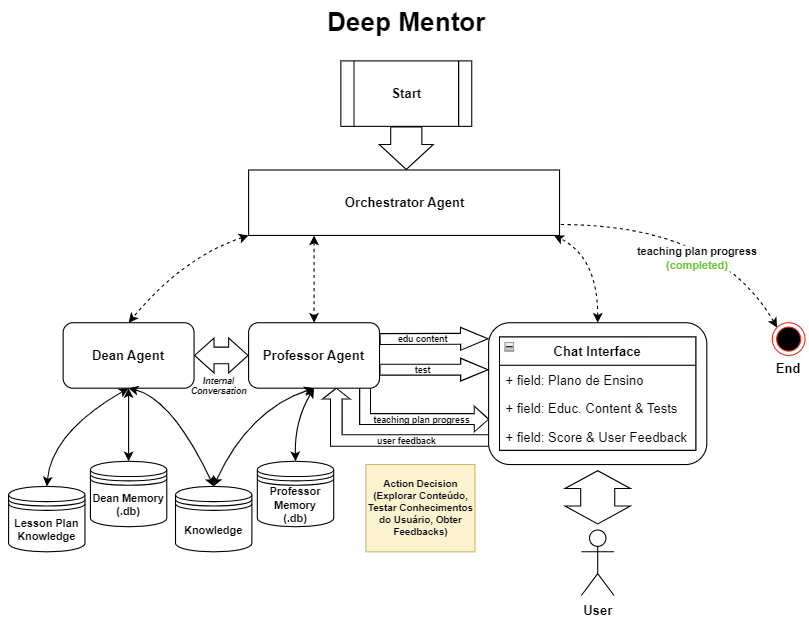

In [ ]:
# Contagem de tokens (biblioteca tiktokens)
encoding = tiktoken.encoding_for_model(gpt_model)
def count_tokens(string: str) -> int:
    """Returns the number of tokens in a text string."""
    return len(encoding.encode(string))

#@title Tópicos da Simulação
topico_geral = "Deep Learning" #@param ["Deep Learning"]
topico_especifico = "Regressão Linear" #@param ["Regressão Linear", "Redes Neurais Convolucionais (CNNs)", "Redes Neurais Recorrentes (RNNs)"]
ref_topico_especifico = "chapter-3" #@param ["summary", "chapter-3"]

print(f"Tema: {topico_geral}")
print(f"Tópico Específico: {topico_especifico}")
print(f"Referência Tópico Específico: {ref_topico_especifico}")
print(f"Conteúdo:")

# Percorrer todas as páginas e contar tokens
token_report = {}

for section, pages in ocr_content_dict.items():
    token_report[section] = {}
    for page, content in pages.items():
        text = content.get("text", "")
        num_tokens = count_tokens(text)
        token_report[section][page] = num_tokens
        print(f"Seção: {section} | Página: {page} → {num_tokens} tokens")

# Se quiser, pode somar o total por seção:
for section in token_report:
    total = sum(token_report[section].values())
    print(f"Total de tokens em '{section}': {total}")

Tema: Deep Learning
Tópico Específico: Regressão Linear
Referência Tópico Específico: chapter-3
Conteúdo:
Seção: summary | Página: 3 → 212 tokens
Seção: summary | Página: 4 → 788 tokens
Seção: summary | Página: 5 → 785 tokens
Seção: summary | Página: 6 → 463 tokens
Seção: summary | Página: 7 → 508 tokens
Seção: summary | Página: 8 → 746 tokens
Seção: summary | Página: 9 → 802 tokens
Seção: summary | Página: 10 → 786 tokens
Seção: summary | Página: 11 → 485 tokens
Seção: summary | Página: 12 → 475 tokens
Seção: summary | Página: 13 → 795 tokens
Seção: summary | Página: 14 → 446 tokens
Seção: summary | Página: 15 → 578 tokens
Seção: summary | Página: 16 → 765 tokens
Seção: summary | Página: 17 → 782 tokens
Seção: summary | Página: 18 → 821 tokens
Seção: summary | Página: 19 → 544 tokens
Seção: summary | Página: 20 → 829 tokens
Seção: summary | Página: 21 → 849 tokens
Seção: summary | Página: 22 → 811 tokens
Seção: summary | Página: 23 → 463 tokens
Seção: summary | Página: 24 → 122 tokens

In [ ]:
#llm=LLM(
#    model="ollama/gpt-oss:20b",
#    base_url=OLLAMA_BASE_URL,
#    temperature=0.7
#),

llm=LLM(
    model=gpt_model,
    base_url="https://api.openai.com/v1",
    api_key=os.environ["OPENAI_API_KEY"],
    #temperature=0.7 # modelo não suporta alteração da temperatura
)

In [ ]:
class OrchestratorAnalysis(BaseModel):
    turn: int             = 0
    next_agent: str       = ""
    next_instruction: str = ""

class InteractionState(BaseModel):
    turn: int                     = 0
    agents: str                   = []
    next_agent: str               = ""
    next_instruction: str         = ""

    user_message: str             = ""
    edu_content: str              = ""
    test_content: str             = ""
    conversation_history: str     = []
    teaching_plan: Dict[str, Any] = {}
    teaching_plan_progress: float = 0.0

    user_feedback: str            = ""
    result: str                   = ""

In [ ]:
class DeepMentorFlow(Flow[InteractionState]):
    # Etapa inicial
    @start()
    def start_method(self):
        print("🚀 DeepMentor v1.0 iniciado.")

        self.state.turn = 0
        self.state.agents = ["professor", "dean", "orchestrator"]
        self.state.next_agent = "orchestrator"
        self.state.next_instruction = "ordering" # [first interaction: ordering]

        self.state.user_message           = ""
        self.state.edu_content            = ""
        self.state.test_content           = ""
        self.state.conversation_history   = []
        self.state.teaching_plan          = {}
        self.state.teaching_plan_progress = 0.0

        self.state.user_feedback          = ""
        self.state.result                 = "" # retornos da Crew

    # Orchestrator
    @router(start_method)
    async def orchestrator_agent(self) -> str:#Dict[str, Any]:
        print("🎯 Orchestrator Agent")
        return "success"

    @listen("success")
    def third_method(self):
        print("Third method running")

deep_mentor_flow = DeepMentorFlow()
plot_path = deep_mentor_flow.plot("DeepMentorFlow.html")
print("Fluxo salvo em:", plot_path)

await deep_mentor_flow.kickoff_async()

╭──────────────────────────────────────────────── Flow Execution ─────────────────────────────────────────────────╮
│                                                                                                                 │
│  Starting Flow Execution                                                                                        │
│  Name: DeepMentorFlow                                                                                           │
│  ID: c3dddecb-fd2d-4b5e-a8e1-767934d95c86                                                                       │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Fluxo salvo em: /tmp/crewai_flow_30y8szlj/DeepMentorFlow.html
Flow started with ID: c3dddecb-fd2d-4b5e-a8e1-767934d95c86
🚀 DeepMentor v1.0 iniciado.


Output()

🎯 Orchestrator Agent

Third method running

╭──────────────────────────────────────────────── Flow Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Flow Execution Completed                                                                                       │
│  Name: DeepMentorFlow                                                                                           │
│  ID: c3dddecb-fd2d-4b5e-a8e1-767934d95c86                                                                       │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [ ]:
print("Conteúdo de:", plot_path)
print(os.listdir(os.path.dirname(plot_path)))

Conteúdo de: /tmp/crewai_flow_uvkv0aua/DeepMentorFlow.html
['DeepMentorFlow_script.js', 'DeepMentorFlow.html', 'DeepMentorFlow_style.css']


In [ ]:
# Get the directory of the plot files from plot_path
plot_dir = os.path.dirname(plot_path)

# Define the files to be included in the ZIP archive
files_to_zip = [
    os.path.join(plot_dir, 'DeepMentorFlow.html'),
    os.path.join(plot_dir, 'DeepMentorFlow_script.js'),
    os.path.join(plot_dir, 'DeepMentorFlow_style.css')
]

zip_filename = 'DeepMentorFlow_Plot.zip'

print(f"Creating {zip_filename}...")

with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for file in files_to_zip:
        if os.path.exists(file):
            zipf.write(file, os.path.basename(file))
            print(f"Added {os.path.basename(file)} to {zip_filename}")
        else:
            print(f"Warning: File not found - {file}")

print(f"Successfully created {zip_filename}. Providing download link...")

if download_flow_graph:
    GFiles.download(zip_filename)

Creating DeepMentorFlow_Plot.zip...
Added DeepMentorFlow.html to DeepMentorFlow_Plot.zip
Added DeepMentorFlow_script.js to DeepMentorFlow_Plot.zip
Added DeepMentorFlow_style.css to DeepMentorFlow_Plot.zip
Successfully created DeepMentorFlow_Plot.zip. Providing download link...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# O DEAN
dean = Agent(
    role='Diretor Acadêmico e Orquestrador (Dean)',
    goal=(
        "Criar plano de ensino sobre o assunto: {topic}. "
        "Analisar o histórico de interações entre agente professor e agente aluno, "
        "com o objetivo de analisar o avanço do aprendizado e o cumprimento do plano de ensino, "
        "e decidir o PRÓXIMO PASSO de interação. Você deve orquestrar a conversa entre o "
        "Professor e o Aluno. Você também decide quando um tópico termina "
        "ou quando a sessão inteira deve ser encerrada. "
        "Crie e grave em sua memória a lista de tópicos "
        "a serem cumpridos do plano de ensino, inicialize com ☐ (referente a incomplete). Você possui três status: "
        "✅ (completed), "
        "☐ (incomplete), "
        "❌ (learning_problem). "
        "Quando lhe for solicitado para responder no formato JSON, responda EXCLUSIVAMENTE em formato JSON válido, conforme instrução solicitada (como prioridade máxima para a resposta)."
    ),
    backstory=(
        "Você é o orquestrador mestre. Você avalia o histórico e decide quem "
        "deve falar em seguida (Professor ou Aluno) e qual é a sua instrução. "
        "Se o aluno aprendeu o tópico, você pode declarar o tópico como 'concluído' e "
        "encerrar a sessão."
    ),
    verbose=True,
    llm=llm,
)

In [ ]:
# O DEAN
dean_storage = CommonStorage()
dean_memory = Memory(storage=dean_storage)

dean = Agent(
    role='Diretor Acadêmico e Orquestrador (Dean)',
    goal=(
        "Criar plano de ensino sobre o assunto: {topic}. "
        "Analisar o histórico de interações entre agente professor e agente aluno, "
        "com o objetivo de analisar o avanço do aprendizado e o cumprimento do plano de ensino, "
        "e decidir o PRÓXIMO PASSO de interação. Você deve orquestrar a conversa entre o "
        "Professor e o Aluno. Você também decide quando um tópico termina "
        "ou quando a sessão inteira deve ser encerrada. "
        "Crie e grave em sua memória a lista de tópicos "
        "a serem cumpridos do plano de ensino, inicialize com ☐ (referente a incomplete). Você possui três status: "
        "✅ (completed), "
        "☐ (incomplete), "
        "❌ (learning_problem). "
        "Quando lhe for solicitado para responder no formato JSON, responda EXCLUSIVAMENTE em formato JSON válido, conforme instrução solicitada (como prioridade máxima para a resposta)."
    ),
    backstory=(
        "Você é o orquestrador mestre. Você avalia o histórico e decide quem "
        "deve falar em seguida (Professor ou Aluno) e qual é a sua instrução. "
        "Se o aluno aprendeu o tópico, você pode declarar o tópico como 'concluído' e "
        "encerrar a sessão."
    ),
    memory=dean_memory,
    verbose=True,
    llm=llm,
)

In [ ]:
# O PROFESSOR
professor = Agent(
    role='Professor Especialista',
    goal=(
        "Ensinar o tópico de {topic} ao agente aluno, seguindo as instruções do Dean via método Socrático. "
        "Você é submisso ao agente Dean que irá instruir quais os seus passos em sala de aula para o ensino. "
        "Importante saber que na primeira interação com o agente aluno deve elaborar o raciocínio acerca do tema {topic}, "
        "em seguida deve decidir se faz perguntas de multipla escolha ou dissertativa para o aluno, deve avaliar o desempenho, "
        "se o desempenho for insatisfatório, elabore novamente um plano de aula para interagir com o aluno até que o desempenho "
        "seja satisfatório, isto é, o aluno acerte de forma adequada a questão. Proceda neste loop de aula e teste até que "
        "o aproveitamento do aluno seja obtido. Após isso reporte para o Dean o status atual do aprendizado (satisfatório ou não satisfatório)."
    ),
    backstory=(
        "Você é um professor especialista Socrático. Você NUNCA dá a resposta direta. "
        "Você responde perguntas com outras perguntas. Você segue a instrução exata "
        "dada pelo Dean em cada turno. Você elabora aulas e as executa acerca de um tópico."
    ),
    verbose=True,
    llm=llm
)

In [ ]:
# O ALUNO
aluno = Agent(
    role='Aluno Agentico',
    goal="Aprender sobre {topic} e interagir com o Professor.",
    backstory=(
        "Você é um estudante curioso e iniciante, não sabe NADA sobre o {topic}. "
        "Você reage às explicações do professor. Se você não entende, você pergunta. "
        "Você tenta responder às perguntas, mesmo que erre. Porém está em um processo de aprendizado e "
        "a cada vez que interage com o professor tende a convergir com os raciocínios."
    ),
    memory=True, # memória ativada para o agente aluno para estimular o aprendizado
    verbose=True,
    llm=llm
)

In [ ]:
# Tarefa de Setup: Criar o plano
task_setup_plano = Task(
    description=(
        f"Criar o plano de ensino para o curso de '{topico_geral}' sobre o tópico específico de '{topico_especifico}'. "
        "O plano deve conter os tópicos necessários para o aprendizado, seguindo um raciocínio lógico para determinar a progressão, "
        "estabelecendo sempre do mais básico ao avançado sobre o tópico específico. Para a avaliação é importante criar "
        "em memória a lista de tópicos a serem cumpridos do plano de ensino, inicialize com ☐ (referente a incomplete). "
        "Você possui três status: ✅ (complete), ☐ (incomplete), ❌ (learning_problem). "
    ),
    expected_output=(
        "Pode discorrer sobre o plano de ensino."
        "Deve mostrar um planejamento com uma lista formatada sobre os tópicos de ensino, e.g., '- Tópico 1\n- Tópico 2...'. "
        "Formato de saída: "
        "[PLANO DE ENSINO]"
        "<redija aqui seu plano de ensino>"
    ),
    agent=dean
)

# 2. Crew de Setup
crew_setup = Crew(agents=[task_setup_plano.agent], tasks=[task_setup_plano])
input = {
    "topic": topico_geral,
    "specific_topic": topico_especifico
}
plano_de_ensino = crew_setup.kickoff(
    inputs=input
)

In [ ]:
plano_de_ensino.raw

In [ ]:
print("🧠 Memória atual:")
for item in dean_memory.storage.load():
    print(f"- {item['value']} (meta: {item['metadata']})")

In [ ]:
# Agente parser
parser_agent = Agent(
    role="Extrator de Dados Focado",
    goal="Extrair um pedaço de informação de um texto, sem adicionar NENHUMA palavra extra.",
    backstory=(
        "Você é um robô de parsing. Você lê um texto e responde *apenas* "
        "com a informação solicitada. Você NUNCA diz 'Aqui está a informação', "
        "'A informação é', ou usa aspas extras."
    ),
    llm=llm,
    verbose=False
)

In [ ]:
# Histórico da conversa para o Dean analisar
conversation_history = [] #[f"Plano de Ensino: {plano_de_ensino}"]
max_turns = 10  # Para evitar loops infinitos
turn = 0

# Mapeia nomes de agentes para os objetos Agente
agents_map = {
    "Professor": professor,
    "Aluno": aluno,
    "Dean": dean
}

# A instrução inicial
next_instruction = (
    "Professor, comece a ensinar o primeiro tópico do plano de ensino ao Aluno, dê prioridade para explorar o "
    "conteúdo do plano de ensino (de forma dissertativa e explicativa) e formular questões de múltipla escolha (até 5 escolhas) "
    "ou questão dissertativa para iniciarmos "
    "a avaliação do aluno e entendermos a profundidade de conhecimento do aluno. Você tem acesso ao plano de ensino abaixo: "
    f"{plano_de_ensino.raw} \n\n"
    "Orientações gerais para explorar na primeira aula: "
    "1. Visão geral do curso; "
    "2. Onde o {specific_topic} se encaixa dentro do {topic}?; "
    "3. Aplicações típicas do {specific_topic} no contexto do {topic}; "
    "4. Por que estudar o {specific_topic}?; "
    "5. Definição de {topic}; "
    "6. Propriedades de {topic}; "
    "7. Casos práticos de implementação em Python; "
    "8. Conclusão; "
    "Exercícios."
)
next_agent_name = "Professor"

while turn < max_turns:
    turn += 1
    print(f"\n--- 🔄 Turno {turn} ---")

    # ---------------------------------
    # SELEÇÃO DO AGENTE E TAREFA
    # ---------------------------------
    if next_agent_name not in agents_map:
        print(f"🚨 Erro: Dean especificou um agente inválido: {next_agent_name}")
        break

    agent_to_run = agents_map[next_agent_name]

    # Cria a tarefa dinâmica
    dynamic_task = Task(
        description=next_instruction,
        expected_output="Sua resposta direta, seguindo seu papel.",
        agent=agent_to_run
    )

    # ---------------------------------
    # EXECUÇÃO DA TAREFA
    # ---------------------------------

    # Cria uma "mini-crew" de 1 agente e 1 tarefa para executar
    task_crew = Crew(agents=[agent_to_run], tasks=[dynamic_task], process=Process.sequential, verbose=0)
    input={
        "topic": topico_geral,
        "specific_topic": topico_especifico
    }
    task_output = task_crew.kickoff(
        inputs=input
    )

    print(f"Resultado:\n{task_output}")
    conversation_history.append(f"{next_agent_name}: {task_output}")

    # ---------------------------------
    # DECISÃO DO DEAN (O Orquestrador)
    # ---------------------------------
    print("\n\n[Dean está pensando...]\n")

    # Cria a tarefa de decisão para o Dean
    # TODO: quebrar em dois agentes (Dean e Orquestrador)
    # Dean:
    # Orquestrador:

    dean_task = Task(
        description=f"""
        Analise o histórico da conversa e o plano de aprendizado.
        O tópico atual é: '{topico_especifico}' do tema de {topico_geral}.
        O plano geral é: {plano_de_ensino}
        Histórico da Conversa:
        ---
        { "\n".join(conversation_history) }
        ---
        Decida a PRÓXIMA AÇÃO. Quem deve falar (Professor ou Aluno) e qual a instrução?
        Ou, se o tópico '{topico_especifico}' foi concluído, defina 'next_agent' como 'Dean'
        e a instrução como 'TÓPICO CONCLUÍDO. Encerrar sessão.'.

        Responda APENAS com um objeto JSON válido, com as chaves "next_agent" e "instruction".
        Exemplo: {{ "next_agent": "Professor", "instruction": "O aluno está confuso sobre 'filtros'. Faça uma analogia." }}
        """,
        expected_output="Um objeto JSON {'next_agent': <next_agent>, 'instruction': <instruction>}.",
        agent=dean
    )

    orchestrator_task = Task(
        description=f"""
        Analise o histórico da conversa e o plano de aprendizado.
        O tópico atual é: '{topico_especifico}' do tema de {topico_geral}.
        O plano geral é: {plano_de_ensino}
        Histórico da Conversa:
        ---
        { "\n".join(conversation_history) }
        ---
        Decida a PRÓXIMA AÇÃO. Quem deve falar (Professor ou Aluno) e qual a instrução?
        Ou, se o tópico '{topico_especifico}' foi concluído, defina 'next_agent' como 'Dean'
        e a instrução como 'TÓPICO CONCLUÍDO. Encerrar sessão.'.

        Responda APENAS com um objeto JSON válido, com as chaves "next_agent" e "instruction".
        Exemplo: {{ "next_agent": "Professor", "instruction": "O aluno está confuso sobre 'filtros'. Faça uma analogia." }}
        """,
        expected_output="Um objeto JSON {'next_agent': <next_agent>, 'instruction': <instruction>}.",
        agent=dean
    )

    # Executa a "mini-crew" do Dean
    dean_crew = Crew(agents=[dean], tasks=[dean_task], process=Process.sequential, verbose=0)
    dean_output = dean_crew.kickoff()

    # Parsing com agente 🌟
    # Tarefa 1: Extrair o Agente
    task_get_agent = Task(
        description=f"""
        Analise o texto a seguir:
        ---
        {dean_output}
        ---
        Qual é o valor da chave "next_agent"?
        Responda APENAS com o nome do agente (ex: 'Professor', 'Aluno', ou 'Dean').
        Não inclua aspas ou qualquer outra palavra.
        """,
        expected_output="Um único nome: 'Professor', 'Aluno', ou 'Dean'.",
        agent=parser_agent
    )
    crew_get_agent = Crew(agents=[parser_agent], tasks=[task_get_agent], verbose=0)
    next_agent_name_raw = crew_get_agent.kickoff()

    # Tarefa 2: Extrair a Instrução
    task_get_instruction = Task(
        description=f"""
        Analise o texto a seguir:
        ---
        {dean_output}
        ---
        Qual é o valor da chave "instruction"?
        Responda APENAS com o texto completo da instrução.
        Não inclua "A instrução é:" ou qualquer outra palavra.
        """,
        expected_output="O texto exato da instrução.",
        agent=parser_agent
    )
    crew_get_instruction = Crew(agents=[parser_agent], tasks=[task_get_instruction], verbose=0)
    next_instruction_raw = crew_get_instruction.kickoff()

    # Limpeza final (ainda necessária para garantir)
    next_agent_name = next_agent_name_raw.raw
    next_instruction = next_instruction_raw.raw

    print(f"\n--- [Parser Decidiu] ---")
    print(f"Próximo Agente: {next_agent_name}")
    print(f"Próxima Instrução: {next_instruction}")
    print("------------------------")

    # ---------------------------------
    # VERIFICAÇÃO DE FIM DE LOOP (Agora sem o try/except)
    # ---------------------------------
    if not next_agent_name or not next_instruction or "erro" in next_agent_name.lower():
        print(f"🚨 ERRO: O Agente Parser falhou em extrair dados. Encerrando.")
        print(f"Raw Agent: {next_agent_name_raw}")
        print(f"Raw Instruction: {next_instruction_raw}")
        break

    if next_agent_name.lower() == "dean":
        print(f"--- [Dean] FIM DA SESSÃO: {next_instruction} ---")
        if "concluído" in next_instruction.lower():
            # Assumindo que relatorio_global e topico_especifico estão definidos
            relatorio_global.marcar_aprendido(topico_especifico)
        break